# Introduction
Branches in CPU instructions are often a major reason for performance hits as work done in parts of the CPU pipeline has to be discarded and the target instruction address of the branch has to be calculated and fetched. As modern pipelines get more complicated, the slow down caused by branches increases. There are many different ways to lessen the impact of branching, such as a branch delay slot, multiple instruction streams and branch prediction. 

In this practical, we focus on different branch prediction strategies by writing a branch predictor simulator to simulate the strategies over a series of execution traces from benchmark programs and calculate the misprediction rates. The results are then presented and analysed to understand the effectiveness of different strategies on different types of programs. 

The following branch prediction strategies were simulated and analysed:
- Always taken
- Always not taken
- 2-bit predictor
- Correlating predictor
- Gshare
- Profiled approach

# Design 

## Benchmark programs
It is important to have a set of benchmarks with varied behaviour to understand the differences in the differnt branch prediction strategies. 

## Simulator implementation
Here we give a brief overview of the code written for the simulator.

In [2]:
from enum import Enum

class Branch(Enum):
    NOT_TAKEN = 0
    TAKEN = 1

The `Branch` enum represents whether the branch was taken or not. An enum is used instead of 0 and 1 to make it clear and avoid mistakes and errors.


In [3]:
class Step:
    def __init__(self, address, branch):
        self.address = address
        self.branch = branch

`Step` contains the address of the instruction as well as whether or not that branch was taken - stored in `self.branch`. This is the representation of each step of the execution trace.

In [4]:
from abc import ABC, abstractmethod

class Predictor(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def predict_correct(self, step):
        pass
    
    def translate_address(self, address, table_bits):
        mask = 2 ** table_bits - 1
        return int(address) & mask
    
    def simulate(self, execution):
        correct_prediction_count = 0

        for step in execution:
            if self.predict_correct(step):
                correct_prediction_count += 1

        return correct_prediction_count / len(execution) * 100

The `Predictor` is the abstract class that our branch prediction strategies will extend. There are a few common functions defined here:
- `predict_correct` function will take a step in the execution and return whether or not the predictor predicted correctly. The function also updates the predictor's strategy accordingly, for example changing the bits in the two bit predictor
- `translate_address` applies a mask to the given address to get the bottom portion of the address within the table size.
- `simulate` will take the entire execution trace and return the percentage of correct branches that the predictor predicted.


## Branch prediction strategies

### Always taken and Always not taken

Always taken and always not taken are the simplest strategies and do as their names suggest.

In [5]:
class AlwaysTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

In [6]:
class AlwaysNotTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

### Two-bit predictor

The two-bit predictor uses two bits as history bits. The prediction is based off the most significant bit of the counter. The history serves as an indicator as to the recent behaviour of the branch (i.e, if the branch was taken the last few times, it will likely be taken again so predict that it is taken). 

![Two-bit predictor](imgs/TwoBitPredictor.jpg)

The two-bit predictor includes a branch history table for addresses to index into to take into account the local history of each branch.

In [7]:
class TwoBitCounter():
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        self.history_bits = (0, 0)
        
    def update(self, prediction_correct):
        self.update_bits(prediction_correct)
        
        if self.history_bits[0]:
            self.prediction = Branch.TAKEN
        else:
            self.prediction = Branch.NOT_TAKEN
            
    def update_bits(self, prediction_correct):
        prediction_value = self.prediction.value
        
        if (prediction_correct):
            self.history_bits = (prediction_value, prediction_value)
        else:
            last_bit = self.history_bits[1]
            self.history_bits = (last_bit, int(not prediction_value))

`TwoBitCounter` is the saturating counter that keeps track of the history of the branch. An important point to notice is that by default, the prediction is set to `Branch.NOT_TAKEN`. This is done deliberately because of the additional cost of computing the branch target address. It is less costly to continue the next instruction in sequence rather than assume and calculate the address of the taken branch.

In [8]:
class TwoBitPredictor(Predictor):
    def __init__(self, table_bits):
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.table[address]
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        return prediction_correct

The `TwoBitPredictor` fetches the corresponding counter from its predictor table for its prediction and then updates the counter afterwards.

### Correlating predictor

The correlating predictor lets us have multiple two-bit counters per branch. A shift register will tell the predictor which counter to choose for each branch. This strategy takes into account the global history - the shift register - rather than just the local history of each branch. Depending on the global history of the shift register, it indexes to different two-bit counters on the same branch.

In [9]:
class CorrelatingCounter():
    def __init__(self, register_bits):
        self.two_bit_counters = [TwoBitCounter() for i in range(2 ** register_bits)]

    def prediction(self, shift_register):
        counter = self.two_bit_counters[shift_register]
        return counter.prediction
    
    def update(self, prediction_correct, shift_register):
        counter = self.two_bit_counters[shift_register]
        counter.update(prediction_correct)

The `CorrelatingCounter` must have 2<sup>n</sup> `TwoBitCounter`s where *n* is the number of bits in the shift register. To get a prediction, the shift register must be passed so we can fetch the corresponding two-bit counter in the list. 

In [10]:
class CorrelatingPredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a CorrelatingCounter for each entry in the table
        inner_predictors = enumerate([CorrelatingCounter(register_bits) for i in range(2 ** table_bits)])
        self.table = {address: ip for (address, ip) in inner_predictors}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
    
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        inner_predictor = self.table[address]
        prediction = inner_predictor.prediction(self.shift_register)
        
        prediction_correct = prediction == step.branch
        inner_predictor.update(prediction_correct, self.shift_register)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1
        
        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)

The shift register represents the global history of the previous *n* branches where *n* is the number of bits in the shift register. The register is updated by bit shifting 1 to the right after every step. Then, if the branch was taken, add a 1 to the n<sup>th</sup> bit.

### Gshare

The Gshare predictor indexes by XORing the address and the shift register to index into the predictor table. It is a strategy proposed by McFarling to hash the global history (shift register) and branch address to gain more information than either alone. 

In [27]:
class GsharePredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.get_inner_predictor(address)
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
    
    def get_inner_predictor(self, address):
        index = address ^ self.shift_register
        return self.table[index]
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1

        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)

## Profiled approach <a id='profiled_approach'></a>

# Experiments

To start testing and experimenting with the branch trace files, we need to parse the file into a list of `Step`.

In [12]:
def createStep(address, taken_bit):
    if (taken_bit == '1'):
        return Step(address, Branch.TAKEN)
    else:
        return Step(address, Branch.NOT_TAKEN)

def parseTrace(file):
    lines = file.read().splitlines()
    steps = [line.split(" ") for line in lines]
        
    execution = [createStep(step[0], step[1]) for step in steps]
    return execution

`parseTrace` will return the execution trace as a list of steps that we can pass to our predictors. We can see how this works below:

In [14]:
always_taken = AlwaysTakenPredictor()
always_not_taken = AlwaysNotTakenPredictor()

testfile = open("echohello.out", "r")
execution = parseTrace(testfile)

In [15]:
taken_percentage = always_taken.simulate(execution)
not_taken_percentage = always_not_taken.simulate(execution)

print("Always taken: " + str(taken_percentage))
print("Always not taken: " + str(not_taken_percentage))

Always taken: 51.27696148651414
Always not taken: 48.72303851348586


In [44]:
twobits = [TwoBitPredictor(9), TwoBitPredictor(10), TwoBitPredictor(11), TwoBitPredictor(12)]
twobits_data = []
for p in twobits:
    twobits_data.append((len(p.table), p.simulate(execution)))

In [45]:
correlators = [CorrelatingPredictor(9, 2), CorrelatingPredictor(10, 2), CorrelatingPredictor(11, 2), CorrelatingPredictor(12, 2)]
c_data = []
for p in correlators:
    c_data.append((len(p.table), p.simulate(execution)))

In [46]:
gshares = [GsharePredictor(9, 2), GsharePredictor(10, 2), GsharePredictor(11, 2), GsharePredictor(12, 2)]
g_data = []
for p in gshares:
    g_data.append((len(p.table), p.simulate(execution)))

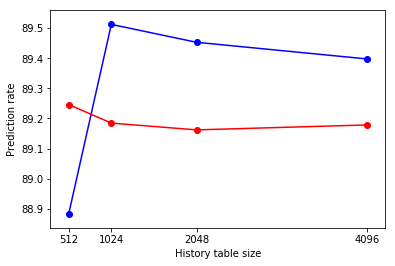

In [51]:
from matplotlib import pyplot as plt
plt.ylabel("Prediction rate")
plt.xlabel("History table size")
plt.xticks([512, 1024, 2048, 4096])
plt.scatter(*zip(*twobits_data), c='b')
plt.scatter(*zip(*c_data), c='r')
plt.plot(*zip(*twobits_data), c='b')
plt.plot(*zip(*c_data), c='r')
plt.show()

# References
- http://web.cs.ucdavis.edu/~su/Berkeley/cs252/project.html
- https://www2.eecs.berkeley.edu/Pubs/TechRpts/1983/CSD-83-121.pdf
- http://web.engr.oregonstate.edu/~benl/Projects/branch_pred/
- http://www.hpl.hp.com/techreports/Compaq-DEC/WRL-TN-36.pdf
- http://math.nist.gov/scimark2/about.html
